In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

pd.set_option("display.max_columns", None)

In [61]:
clean_df = pd.read_csv("./datasets/datafiniti/1429_1.csv", low_memory=False, 
                 usecols=['reviews.text', 'reviews.rating'])
clean_df['reviews.sentiment'] = clean_df['reviews.rating'].apply(lambda x: 1 if x >= 4.0 else 0)
clean_df.head()

reviews.rating                                       reviews.text  \
0             5.0  This product so far has not disappointed. My c...   
1             5.0  great for beginner or experienced person. Boug...   
2             5.0  Inexpensive tablet for him to use and learn on...   
3             4.0  I've had my Fire HD 8 two weeks now and I love...   
4             5.0  I bought this for my grand daughter when she c...   

   reviews.sentiment  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [62]:
clean_df = clean_df.dropna()

In [63]:
scraped_df = pd.read_csv("./datasets/Reviews.csv", low_memory=False,
                         usecols=['reviews.text', 'reviews.rating'])
scraped_df['reviews.sentiment'] = scraped_df['reviews.rating'].apply(lambda x: 1 if x >= 4.0 else 0)
scraped_df = scraped_df.dropna()

In [ ]:
# scraped_df['reviews.text'].to_list()[:500]

In [64]:
scraped_df.isna().sum()

reviews.rating       0
reviews.text         0
reviews.sentiment    0
dtype: int64

In [65]:
df = pd.concat([clean_df, scraped_df])

In [66]:
df = df[['reviews.text', 'reviews.sentiment']]

Positive labels %: 40.330
Negative labels %: 59.670


<AxesSubplot:>

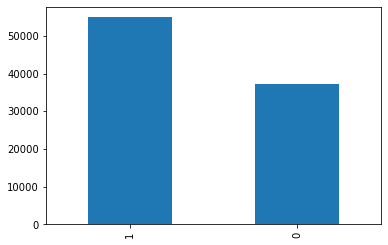

In [67]:
print(f"Positive labels %: {(df['reviews.sentiment'].value_counts()[0]/len(df)) * 100:.3f}")
print(f"Negative labels %: {(df['reviews.sentiment'].value_counts()[1]/len(df)) * 100:.3f}")
df['reviews.sentiment'].value_counts().plot(kind='bar')

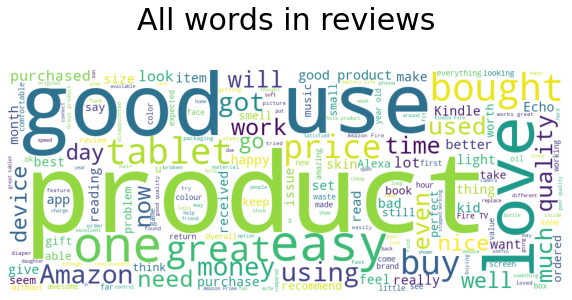

In [68]:
text = df['reviews.text']
wordcloud = WordCloud(background_color='white',
                     width=1000,
                     height=400).generate(" ".join(text))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title("All words in reviews\n", size=30)
plt.axis('off')
plt.show()

In [72]:
# max_features = 2000
# tokenizer = Tokenizer(num_words=max_features, split=' ')
# tokenizer.fit_on_texts(df['reviews.text'].values)
# X = tokenizer.texts_to_sequences(df['reviews.text'].values)
# X = pad_sequences(X)

In [73]:
# embed_dim = 128
# lstm_out = 196

# model = Sequential()
# model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1571, 128)         256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 1571, 128)        0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
#lowercase all text
df['reviews.text'] = df['reviews.text'].str.lower()

#tokenization
df['reviews.text'] = df.apply(lambda row: word_tokenize(
    row['reviews.text']), axis=1)

In [77]:
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:[item for item in x if item.isalpha()])

#lemmatize
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:[WordNetLemmatizer().lemmatize(y) for y in x])

#remove stopwords
stop_words = stopwords.words('english')
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:[item for item in x if item not in stop_words])

In [79]:
df['reviews.text'] = df['reviews.text'].apply(
    lambda x:str(' '.join(x)))

In [80]:
df.head()

reviews.text  reviews.sentiment
0  product far ha disappointed child love use lik...                  1
1  great beginner experienced person bought gift ...                  1
2  inexpensive tablet use learn step nabi wa thri...                  1
3  ive fire hd two week love tablet great valuewe...                  1
4  bought grand daughter come visit set user ente...                  1

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
text = vectorizer.fit_transform(df['reviews.text'])

In [101]:
print(text.shape)

(91995, 48790)


In [102]:
X_train, X_test, y_train, y_test = train_test_split(text, 
                                                    df['reviews.sentiment'],
                                                    test_size=0.2,
                                                    random_state=42)

In [103]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=25535)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

from sklearn.metrics import classification_report

print("Training Classification Report:")
print(classification_report(y_train, y_pred_train))
print()
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

Training Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     29688
           1       0.90      0.92      0.91     43908

    accuracy                           0.89     73596
   macro avg       0.89      0.88      0.88     73596
weighted avg       0.89      0.89      0.89     73596


Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      7414
           1       0.89      0.89      0.89     10985

    accuracy                           0.87     18399
   macro avg       0.86      0.86      0.86     18399
weighted avg       0.87      0.87      0.87     18399



In [119]:
input_text = """I am only using it for 1 week. Thus I have no idea about how long it will last, but the product quality seems very good. My foot is around 25.6-25.8 and I ordered size 8. It fits perfectly. The only thing I didn't like is the Laces. They seemed very long to me and the flat laces often get loose. The shoe attracts dust and can be easily cleaned with a dry cloth. However, I am very happy with the product. Nice quality
and design at the affordable price range (I bought the blue one at Rs 719 - Rs 50, UPI offer)."""
input_text = word_tokenize(input_text.lower())
input_text = [word for word in input_text if word.isalpha()]
input_text = [WordNetLemmatizer().lemmatize(word) for word in input_text]
input_text = [word for word in input_text if word not in stop_words]
print(input_text)

input_text = vectorizer.transform(input_text)

print(input_text.shape)

['using', 'week', 'thus', 'idea', 'long', 'last', 'product', 'quality', 'seems', 'good', 'foot', 'around', 'ordered', 'size', 'fit', 'perfectly', 'thing', 'like', 'lace', 'seemed', 'long', 'flat', 'lace', 'often', 'get', 'loose', 'shoe', 'attracts', 'dust', 'easily', 'cleaned', 'dry', 'cloth', 'however', 'happy', 'product', 'nice', 'quality', 'design', 'affordable', 'price', 'range', 'bought', 'blue', 'one', 'r', 'r', 'upi', 'offer']
(49, 48790)


In [120]:
res=model.predict(input_text)[0]
if res==1:
    print("Good Review")
elif res==0:
    print("Bad Review")

Good Review


In [71]:
# df['reviews.text'] = df['reviews.text'].apply(lambda x: x.lower())
# df['reviews.text'] = df['reviews.text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))
# df['reviews.text'] = df['reviews.text'].apply(lambda x: x.replace('.', ' '))

In [ ]:
# Y = pd.get_dummies(df['reviews.sentiment']).values
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2,
#                                                     random_state = 42)
# print(X_train.shape,Y_train.shape)
# print(X_test.shape,Y_test.shape)

In [ ]:
# from tqdm.keras import TqdmCallback
# batch_size = 1024
# model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, 
#           verbose=0, callbacks=[TqdmCallback(verbose=2)])